# <center>CITS5508 Lab sheet 3</center>

**Name:** Alastair Mory<br>
**Student number:** 21120848<br>


A voting classifier consisting of SVM, logistic regression and gradient descent classifiers will be used on a classification task involving cellular localisation site of proteins from E. coli bacteria. The data set was obtained [here](https://archive.ics.uci.edu/ml/datasets/ecoli). The data set file is unlabeled, however a data set [description file](https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.names) lists both the attribute and class label information.


<br><b>Contents</b><br>
[1 E. Coli Classification Data](#1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Data Visualisation and Statistics](#1.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Data Preprocessing](#1.2)<br>
[2 Classification](#2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Support Vector Machine](#2.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Logistic Regression](#2.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Stochastic Gradient Descent](#2.3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Ensemble Voting](#2.4)<br>
[3 Conclusion](#3)<br>

In [1]:
from typing import Any, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import ensemble, linear_model, metrics, model_selection, preprocessing, svm


# Constants
DATA_COLUMNS = ['Sequence Name', 'mcg', 'gvh', 'lip',
          'chg', 'aac', 'alm1', 'alm2', 'class']

COLUMNS_TO_DROP = ['Sequence Name', 'class']
CLASSES_TO_DROP = ['omL', 'imL', 'imS']

# 1 E. Coli Classification Data <a name="1">

#### Attribute Information:

  **Sequence Name:** Accession number for the SWISS-PROT database (removed)<br>
  **mcg:** McGeoch's method for signal sequence recognition. <br>
  **gvh:** von Heijne's method for signal sequence recognition. <br>
  **lip:** von Heijne's Signal Peptidase II consensus sequence score.
       Binary attribute. <br>
  **chg:** Presence of charge on N-terminus of predicted lipoproteins.
	   Binary attribute. <br>
  **aac:** score of discriminant analysis of the amino acid content of
	   outer membrane and periplasmic proteins. <br>
  **alm1:** score of the ALOM membrane spanning region prediction program. <br>
  **alm2:** score of ALOM program after excluding putative cleavable signal
	   regions from the sequence. <br>
       

#### Class Distribution (the class is the localisation site):

      cp  (cytoplasm)                                    143
      im  (inner membrane without signal sequence)        77               
      pp  (perisplasm)                                    52
      imU (inner membrane, uncleavable signal sequence)   35
      om  (outer membrane)                                20
      omL (outer membrane lipoprotein)                     5 (removed)
      imL (inner membrane lipoprotein)                     2 (removed)
      imS (inner membrane, cleavable signal sequence)      2 (removed)


In [2]:
# Read data in
data = pd.read_csv('./ecoli.data', delim_whitespace=True, names=DATA_COLUMNS)

# Display example rows
data.head()


,Sequence Name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


## 1.1 Data Visualisation and Statistics <a name="1.1">

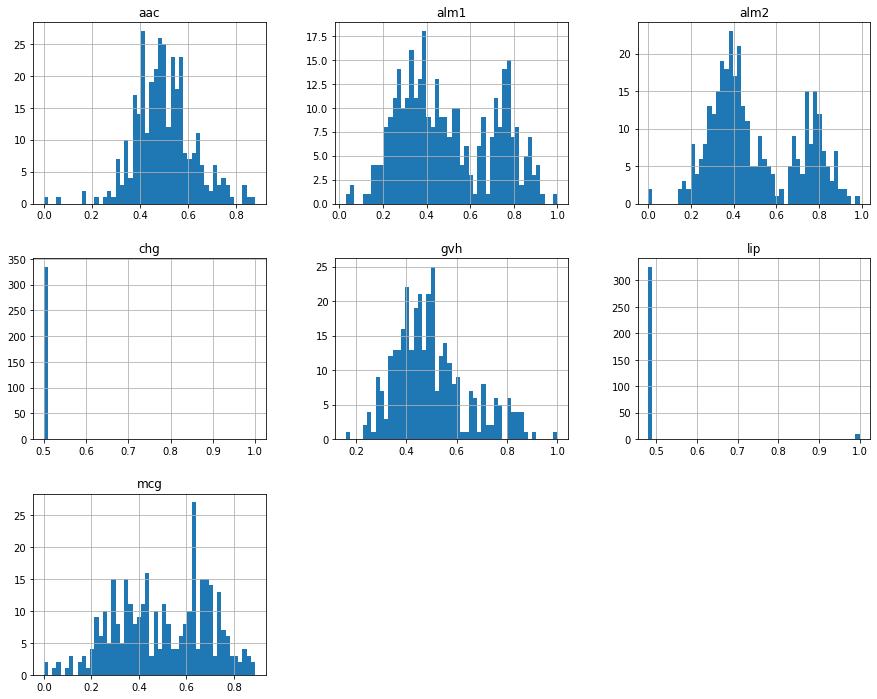

In [3]:
# Histogram of numerical features
%matplotlib inline
data.hist(bins=50, figsize=(15,12))
plt.show()

In [4]:
# Statistics for numerical features
data.describe()

,mcg,gvh,lip,chg,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


From the above plots and statistics we can see a variety of distributions, some relatively normal (aac, gvh & mcg), some bimodal (alm1 & alm2), and some binary attributes (chg & lip). Additionally there is one non-numerical attribute ('Sequence Name') that will not be used.

## 1.2 Data Preprocessing <a name="1.2">

Remove unused attributes and datapoints, perform train / test split and normalise data.


In [5]:
def drop_unused_data(data: pd.DataFrame,
               drop_classes: List[str]=CLASSES_TO_DROP,
               drop_columns: List[str]=COLUMNS_TO_DROP
              ) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Drop rows containing data for classes in drop_classes and remove columns
    contained in drop_columns.
    Returns a tuple containing (x, y) where x is a dataframe of attributes
    excluding the class labels and y is a series of class labels.
    """
    drop_indexes = []
    for i in range(len(data)):
        if data.loc[i, 'class'] in drop_classes:
            drop_indexes.append(i)
    data = data.drop(index=drop_indexes)
    data.reset_index()
    
    y = data['class']
    x = data.drop(columns=drop_columns)
    return x, y


# Perform 80/20 train test split
train, test = model_selection.train_test_split(data,
                                               test_size=0.2,
                                               train_size=0.8)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


# Remove unused classes & columns
train_x, train_y = drop_unused_data(train)
test_x, test_y = drop_unused_data(test)


# Normalise data
scaler = preprocessing.StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)


# 2 Classification <a name="2">

In [6]:
def print_metrics(clf: Any,  # pretrained classifier
                  test_x: pd.DataFrame, test_y: pd.Series,
                  clf_name='Classifier') -> None:
    """
    Run prediction using provided trained classifier and show confusion matrix, accuracy and f1 scores. 
    """
    
    # Run classifier prediction
    pred_y = clf.predict(test_x)
    
    # Calculate accuracy & F1 score
    accuracy = metrics.accuracy_score(test_y, pred_y)
    f1 = metrics.f1_score(test_y, pred_y, average='weighted')
    # Place in dataframe for prettier printing
    scores = pd.DataFrame(data=[[accuracy, f1]],
                          index=[""],
                          columns=['Accuracy', 'F1 Score'])
    
    # Display confusion matrix and metric scores
    metrics.plot_confusion_matrix(clf, test_x, test_y, 
                              normalize='true',
                              cmap=plt.cm.Blues,)
    print(f"{clf_name} Metrics:\n")
    print(scores)

## 2.1 Support Vector Machine <a name="2.1"/>

The support vector classifier was tested with four different kernels (rbf, linear, sigmoid and poly) and linear was found to have the highest accuracy and f1 score for this dataset.

SVM Metrics:

  Accuracy  F1 Score
  0.880597  0.880157


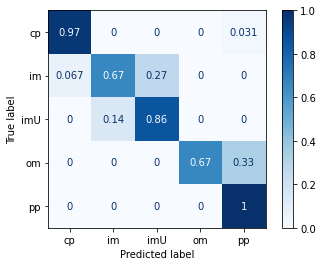

In [7]:
clf_svm = svm.SVC(kernel='linear').fit(train_x, train_y)

print_metrics(clf_svm, test_x, test_y, 'SVM')

## 2.2 Logistic Regression <a name="2.2">
    
For this logistic regression classifier, the maximum iterations needed to be increased significantly (from default max_iter=100 to max_iter=1000) in order to allow it to converge on an appriopriate classification model.

Logistic Regression Metrics:

  Accuracy  F1 Score
  0.865672  0.863236


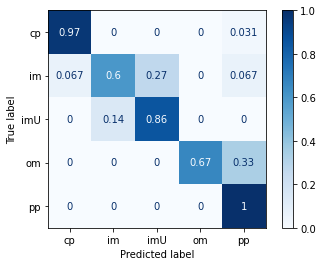

In [8]:
clf_lr = linear_model.LogisticRegressionCV(solver='lbfgs', max_iter=1000).fit(train_x, train_y)

print_metrics(clf_lr, test_x, test_y, 'Logistic Regression')

## 2.3 Stochastic Gradient Descent <a name="2.3">

This stochastic gradient descent classifier achieves an accuracy and f1 score in the 80-90% range, this variation is due to the random nature of training this kind of classifier.

SGD Metrics:

  Accuracy  F1 Score
   0.80597   0.79807


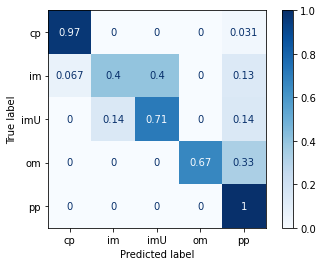

In [9]:
clf_sgd = linear_model.SGDClassifier(loss='hinge').fit(train_x, train_y)

print_metrics(clf_sgd, test_x, test_y, 'SGD')

## 2.4 Ensemble Voting <a name="2.4"/>

The ensemble classifier consists of multiple classifiers that 'vote' on the correct class, ultimately selecting the class that is chosen by a preponderance of its constituent classifiers.

Voting Metrics:

  Accuracy  F1 Score
  0.865672  0.863236


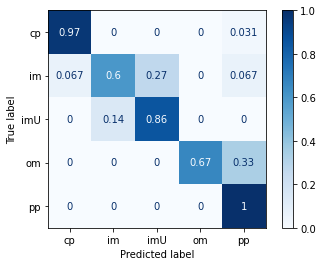

In [10]:
classifiers = [('svm', clf_svm), ('lr', clf_lr), ('sgd', clf_sgd)]
clf_voting = ensemble.VotingClassifier(classifiers).fit(train_x, train_y)

print_metrics(clf_voting, test_x, test_y, 'Voting')

# 3 Conclusion <a name="3"/>

 In this case the support vector and logistic regression classifiers had very close results (generally classifying only 1-2 datapoints differently), so the ensemble voting classifier performed almost identically to them (as with 2/3 classifiers agreeing in almost every case, the SGD classifier's results were largely irrelevant).
 
 It should be noted that 3 constituent classifiers (estimators) is the bare minimum for a useful voting classifier (when using 'hard' voting), as such it would be worth investigating voting classifiers with more estimators (either more different kinds of classifiers, or classifiers of the same type with different hyperparameters) and trying soft voting (where class probabilities are used instead of a majority vote).
    